### Recap: The Learning Problem

We have a large dataset of $(x, y)$ pairs where $x$ denotes a vector of features and $y$ denotes the label for that feature vector. We want to learn a function $h(x)$ that maps features to labels, with good generalization accuracy. We do this by minimizing a loss function computed on our dataset: $ \sum_{i=1}^{N} L(y_i, h(x_i)) $. There are many loss functions we can choose. We have gone over the cross-entropy loss and variants of the squared error loss functions in previous workshops, and we will once again consider those today. 


### Review: A Single "Neuron", aka the Perceptron

![perceptron](https://raw.githubusercontent.com/rohan-varma/rohan-blog/gh-pages/images/perceptron.png)

A single perceptron first calculates a **weighted sum** of our inputs. This means that we multiply each of our features $(x_1, x_2, ... x_n) \in x$ with an associated weight $(w_1, w_2, ... w_n)$ . We then take the sign of this linear combination, which and the sign tells us whether to classify this instance as a positive or negative example.

$h(x) = sign(w^Tx + b) $

We then moved on to logistic regression, where we changed our sign function to instead be a sigmoid ($\sigma$) function. As a reminder, here's the sigmoid function: 

![sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/600px-Logistic-curve.svg.png)

Therefore, the function we compute for logistic regression is $h(x) = \sigma (w^Tx + b)$. 

The sigmoid function is commonly referred to as an "activation" function. When we say that a "neuron computes an activation function", it means that a standard linear combination is calculated ($w^Tx + b$) and then we apply a _non linear_ function to it, such as the sigmoid function. 

Here are a few other common activation functions: 

![tanh](http://www.dplot.com/functions/tanh.png)
![relu](https://i.stack.imgur.com/8CGlM.png)


### Review: From binary to multi-class classification

The most important change in moving from a binary (negative/positive) classification model to one that can classify training instances into many different classes (say, 10, for MNIST) is that our vector of weights $w$ changes into a matrix $W$. 

Each row of weights we learn represents the parameters for a certain class: 

![weights](https://raw.githubusercontent.com/rohan-varma/rohan-blog/gh-pages/images/imagemap.jpg)

We also want to take our output and normalize the results so that they all sum to one, so that we can interpret them as probabilities. This is commonly done using the _softmax_ function, which takes in a vector and returns another vector who's elements sum to 1, and each element is proportional in scale to what it was in the original vector. In binary classification we used the sigmoid function to compute probabilities. Now since we have a vector, we use the softmax function.  

Here is our current model of learning, then:

$h(x) = softmax(Wx + b) $. 

### Building up the neural network

Now that we've figured out how to linearly model multi-class classification, we can create a basic neural network. Consider what happens when we combine the idea of artificial neurons with our softmax classifier. Instead of computing a linear function  $Wx + b$ and immediately passing the output to a softmax function, we have an intermediate step: pass the output of our linear combination to a vector of artificial neurons, which each compute a nonlinear function. 

The output of this "layer" of neurons can be multiplied with a matrix of weights again, and we can apply our softmax function to this result to produce our predictions. 

** Original function **: $h(x) = softmax(Wx + b)$

** Neural Network function **: $h(x) = softmax(W_2(nonlin(W_1x + b_1)) + b_2)$

The key differences are that we have more biases and weights, as well as a larger composition of functions. This function is harder to optimize, and introduces a few interesting ideas about learning the weights with an algorithm known as backpropagation.

This “intermediate step” is actually known as a hidden layer, and we have complete control over it, meaning that among other things, we can vary the number of parameters or connections between weights and neurons to obtain an optimal network. It’s also important to notice that we can stack an arbitrary amount of these hidden layers between the input and output of our network, and we can tune these layers individually. This lets us make our network as deep as we want it. For example, here’s what a neural network with two hidden layers would look like:

![neuralnet](https://raw.githubusercontent.com/rohan-varma/rohan-blog/gh-pages/images/neuralnet.png)

### Quick Example

First, we'll run through a quick example on MNIST. We'll make sure that we can train a basic autoencoder, and see how it performs on reproducting MNIST image. Let's get started with some imports and helper functions to plot images.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


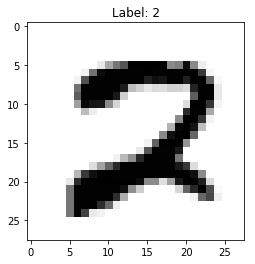

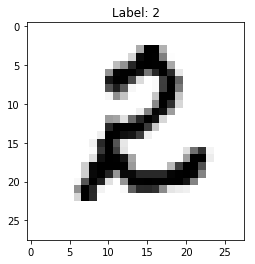

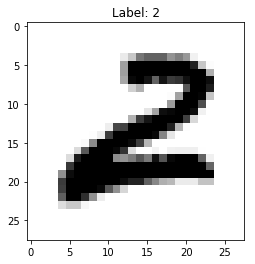

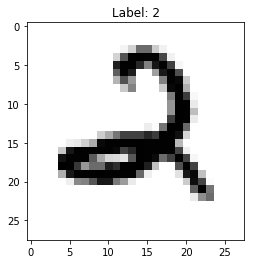

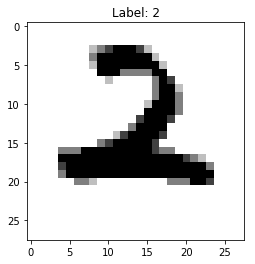

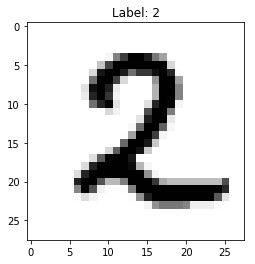

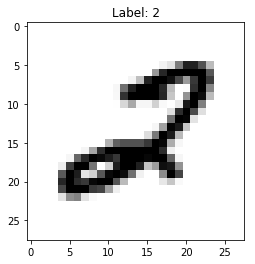

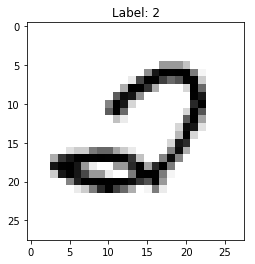

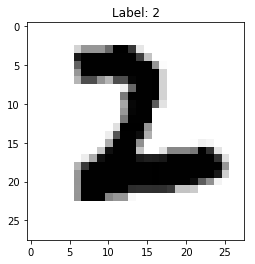

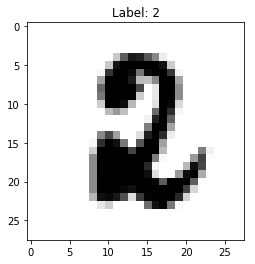

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow.examples.tutorials.mnist import input_data
!pip install -q keras
import keras
from keras.datasets import cifar10
mnist = input_data.read_data_sets('MNIST_data', one_hot=True) # reads in the MNIST dataset


# a function that shows examples from the dataset. If num is specified (between 0 and 9), then only pictures with those labels will beused
def show_pics(mnist, num = None):
    to_show = list(range(10)) if not num else [num]*10 # figure out which numbers we should show
    for i in range(100):
        batch = mnist.train.next_batch(1) # gets some examples
        pic, label = batch[0], batch[1]
        if np.argmax(label) in to_show:
            # use matplotlib to plot it
            pic = pic.reshape((28,28))
            plt.title("Label: {}".format(np.argmax(label)))
            plt.imshow(pic, cmap = 'binary')
            plt.show()
            to_show.remove(np.argmax(label))
            
# a function to plot the genned images
def plot(samples, cur_epoch = None, shape = None):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28,28) if not shape else sample.reshape(shape), cmap='Greys_r')
        # if epoch is not specified we just overwrite the existing image
        plt.show()

    return fig           

#show_pics(mnist)
show_pics(mnist, 2)

### Defining the Model

Below, we'll define our architecture, which will be a fully-connected network that is trained to produce its output. 
We'll also distinguish between transformations that encode images and transformations that take encodings and decode them back into images, and return them both. This is so that we can visualize what features were learned. 

In [6]:
def model(x):
    """Forwards x through the model"""
    dense1 = tf.layers.dense(inputs=x, units = 256, activation = tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1, units = 100, activation = tf.nn.relu)
    encoded_representation = dense2
    dense3 = tf.layers.dense(inputs=dense2, units = 1024, activation = tf.nn.relu)
    logits = tf.layers.dense(inputs=dense3, units = 784)
    return logits, encoded_representation
    # TODO: make 3 dense layers going from 256 -> 100 ->1024
    # TODO: make a final dense layer mapping to ____ outputs
    # return the logits and encoded state.

Next, we'll define our placeholder variables, loss function, and training step.

In [8]:
# TODO: create x and y placeholders. (hint: what shape should they have?)
x = tf.placeholder(tf.float32, shape = [None, 784])
y = tf.placeholder(tf.float32, shape = [None, 784])

# TODO: forward x through the model -> store outputs in logits, encoder
logits, encoder = model(x)
# todo: compute loss (mean squared, using tf.reduce_mean and tf.square.)
# the loss should be stored as training_loss, and it should be mean((y-logits)^2)
training_loss = tf.reduce_mean(tf.square(y - logits))
optim_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(training_loss)

Now, we'll launch a session and run our model without any training for a baseline.

In [9]:
# todo: launch a sess
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [10]:
# todo: sample a small batch
# using the function mnist.train.next_batch(n) where n = 5
x_batch, _ = mnist.train.next_batch(5)

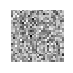

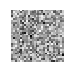

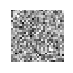

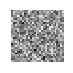

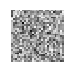

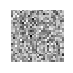

In [16]:
# todo: run the code through a session and plot the decoded images.
decoded_images = sess.run(logits, feed_dict = {x: x_batch})
loss = sess.run(training_loss, feed_dict = {x: x_batch, y: x_batch})
plot(decoded_images)

Cool, that seemed to work. Let's see what happens if we train the model for a little bit:

0.112649


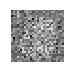

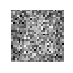

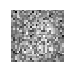

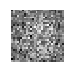

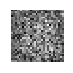

0.0344522


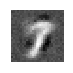

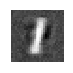

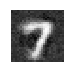

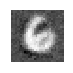

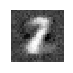

0.0213084


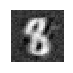

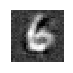

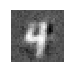

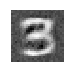

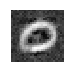

0.0152944


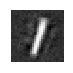

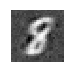

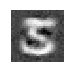

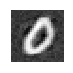

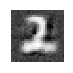

0.0142167


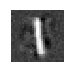

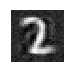

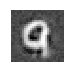

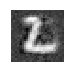

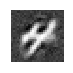

0.0128486


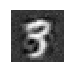

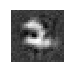

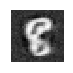

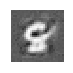

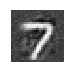

0.0117576


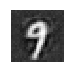

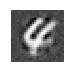

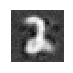

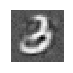

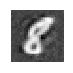

0.0109636


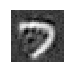

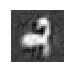

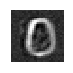

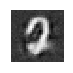

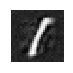

0.0102183


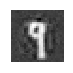

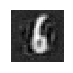

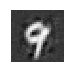

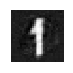

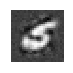

0.0101425


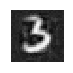

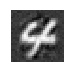

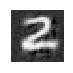

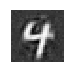

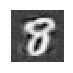

0.00985435


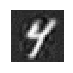

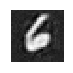

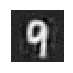

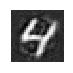

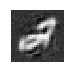

0.00895836


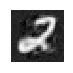

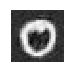

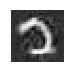

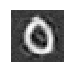

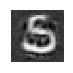

0.00899074


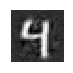

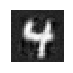

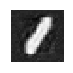

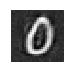

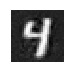

0.00835087


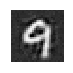

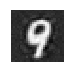

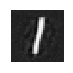

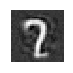

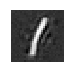

0.00840261


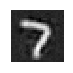

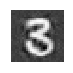

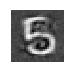

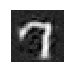

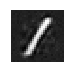

0.00852213


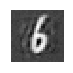

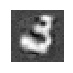

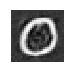

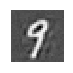

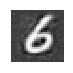

0.00830984


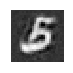

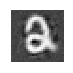

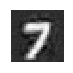

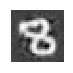

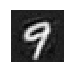

0.00803557


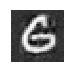

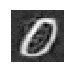

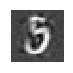

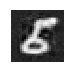

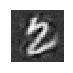

0.00820635


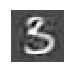

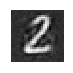

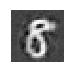

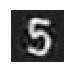

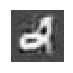

0.00802049


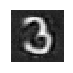

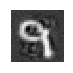

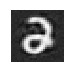

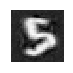

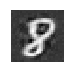

In [17]:
# TODO: fill in the function to generate a batch of random data.
def my_generic_batch(dataset, n = 100):
    # assumes dataset is a tuple of (x_train, y_train)
    x_train, y_train = dataset

    return x_batch, y_batch

# TODO: fill in the function to train the model.
def train_model(optimizer, loss_func, model_logits = logits, dataset = "mnist", n_epochs = 1000, reshape = True):
    # train the model a bit
    for i in range(1000):
        x_batch, _ = mnist.train.next_batch(100) # shape = 37923
        sess.run(optimizer, feed_dict = {x: x_batch, y: x_batch})
        # auxiliary plotting
        if i % 50 == 0:
            cur_loss = loss_func.eval(feed_dict = {x: x_batch, y: x_batch})
            print(cur_loss)
            # sample an image from the model and plot it
            decoded_images = sess.run(model_logits, feed_dict = {x: x_batch[:5]})
            if dataset == "mnist":
                plot(decoded_images)
            else:
                plot(decoded_images, shape = (32, 32, 3))

train_model(optim_step, training_loss)
#train_model(optimizer = optim_step, loss_func = training_loss, model_logits = logits, dataset = "mnist", n_epochs = 1000)        

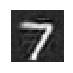

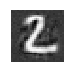

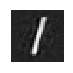

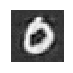

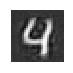

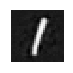

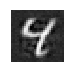

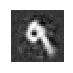

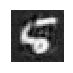

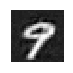

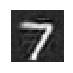

In [22]:
# TODO: sample 10 test points
test_images = mnist.test.images[:10]
decoded_images = sess.run(logits, feed_dict = {x: test_images})
encoding = sess.run(encoder, feed_dict = {x: test_images})
# todo: forward through the model, and get dcoding and encoding.
plot(decoded_images)

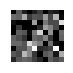

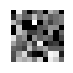

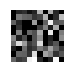

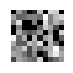

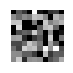

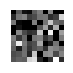

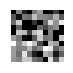

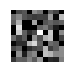

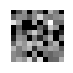

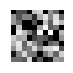

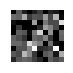

In [23]:
# TODO: plot decoded and encoded images.
plot(encoding, shape = (10, 10))

Cool, our basic autoencoder seemed to work pretty well. Let's look at a few more advanced examples now. For this, we'll use the CIFAR10 dataset. 

#### Aside: Variational Autoencoders

![test](autoenc.jpg)

The above is a simple autoencoder with encode and decode subnetworks (from [Kevin Frans's blog](http://kvfrans.com/variational-autoencoders-explained/)).
We can expand this to build a generative model (again from [Kevin Frans's blog](http://kvfrans.com/variational-autoencoders-explained/)): 

![vae](vae.jpg)

Giving us the following loss (again from [Kevin Frans's blog](http://kvfrans.com/variational-autoencoders-explained/)):
```python
generation_loss = mean(square(generated_image - real_image))  
latent_loss = KL-Divergence(latent_variable, unit_gaussian)  
loss = generation_loss + latent_loss  ```

In [ ]:
cifar10_data = cifar10.load_data()

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
samples = x_train[10:15]
plot(samples, shape = (32, 32, 3))

Let's try our old model again. It's redefined here for convenience (and because we had to change a few shapes). 

In [ ]:
def cifar_model(cifar_in):
    """Forwards x through the model"""
    dense1 = tf.layers.dense(inputs=cifar_in, units=256, activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1, units = 100, activation=tf.nn.relu)
    encoded_representation = dense2 
    # that was the encoding, now let's do the decoding
    dense3 = tf.layers.dense(inputs=dense2, units = 1024, activation = tf.nn.relu)
    logits = tf.layers.dense(inputs=dense3, units=32 * 32 * 3)
    return logits, encoded_representation

def better_cifar_model(cifar_in):
    """Forwards x through the model"""
    # reshape input back into 32, 32, 3
    x = tf.reshape(cifar_in, [-1, 32, 32, 3])
    input_layer = x
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 32 * 10 * 64])
    encoded_representation = pool2_flat
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=True)

  # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=32 * 32 * 3)
    return logits, encoded_representation
    
cifar_x = tf.placeholder(tf.float32, shape = [None, 32 * 32 * 3])
cifar_y = tf.placeholder(tf.float32, shape = [None, 32 * 32 * 3]) # output is itself
# forward x through the model
model_type = "good"
cifar_logits, cifar_encoder = cifar_model(cifar_x) if model_type == "bad" else better_cifar_model(cifar_x)
# compute loss
cifar_training_loss = tf.reduce_mean(tf.square(cifar_y-cifar_logits))
cifar_optim_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cifar_training_loss)